### Thesis ADS: Rosa Lucassen

# Loading the data

In [1]:
import pickle
import pandas as pd
import numpy as np
from numpy import array

import spacy
import stop_words
nlp = spacy.load("en_core_web_sm")
nlp.vocab["covid"].is_stop = True
nlp.vocab["corona"].is_stop = True
nlp.vocab["covid19"].is_stop = True
nlp.vocab["covid-19"].is_stop = True
nlp.vocab["coronavirus"].is_stop = True

import re
import emoji
from collections import Counter
from scipy.stats import chi2_contingency
from urllib.parse import urlparse
from nltk.stem.porter import PorterStemmer

import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

import logging
import pyLDAvis.gensim
import json

import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity
stemmer = PorterStemmer()

# Function: Cleaning data

In [2]:
def remove_single_char(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def remove_numbers(text):
    number_pattern = r'\b(?<![0-9-])(\d+)(?![0-9-])'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number


def remove_urls(text):
    url_pattern = r'https?://\S+|www\.\S+'
    without_urls = re.sub(pattern=url_pattern, repl=" ", string=text)
    return without_urls


def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    without_emoji = emoji_pattern.sub(r'',text)
    return without_emoji

def remove_nonalpha(text):
    nonalpha_pattern = "[+$@#?~]"
    without_nonalpha = re.sub(pattern=nonalpha_pattern, repl=" ", string=text)
    return without_nonalpha
    
def remove_rt(text):
    rt_pattern = 'rt @[\w_]+: '
    without_pattern = re.sub(pattern = rt_pattern, repl=" ", string = text)
    return without_pattern 

def remove_extra_spaces(text):
    space_pattern = r'\s+'
    without_space = re.sub(pattern=space_pattern, repl=" ", string=text)
    return without_space

def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

# Function: BiGrams

In [3]:
from gensim.models import Phrases
def make_n_grams(docs):
    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=1)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    return docs

# Function: Lemmatizing texts

In [4]:
def pre_processer_real(corpus):
    corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_rt(text) for text in corpus]
    corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]
    corpus = strip_list_noempty(corpus)
    
    processed_texts = [text for text in nlp.pipe(corpus, 
                                              disable=["ner",
                                                       "parser"])]
    tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] 
                            for lemma_ in processed_texts]
    tokenized_texts = make_n_grams(tokenized_texts)
    
    flatten = lambda t: [item for sublist in t for item in sublist]
    flat_real = flatten(tokenized_texts)
    counts = Counter(flat_real)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word] #* (10000) / total_words
    return counts, counts.most_common(), flat_real, tokenized_texts

def pre_processer_fake(corpus):
    corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_rt(text) for text in corpus]
    corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]
    corpus = strip_list_noempty(corpus)

    processed_texts = [text for text in nlp.pipe(corpus, 
                                              disable=["ner",
                                                       "parser"])]
    tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] 
                            for lemma_ in processed_texts]
    tokenized_texts = make_n_grams(tokenized_texts)
    
    flatten = lambda t: [item for sublist in t for item in sublist]
    flat_fake = flatten(tokenized_texts)
    counts = Counter(flat_fake)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word] #* (10000) / total_words
    return counts, counts.most_common(), flat_fake, tokenized_texts

# Function: distinctive words

In [5]:
def distinctive_words(target_corpus, reference_corpus):
    counts_c1 = Counter(target_corpus) # don't forget to flatten your texts!
    counts_c2 = Counter(reference_corpus)
    vocabulary = set(list(counts_c1.keys()) + list(counts_c2.keys()))
    freq_c1_total = sum(counts_c1.values()) 
    freq_c2_total = sum(counts_c2.values()) 
    results = []
    for word in vocabulary:
        freq_c1 = counts_c1[word]
        freq_c2 = counts_c2[word]
        freq_c1_other = freq_c1_total - freq_c1
        freq_c2_other = freq_c2_total - freq_c2
        llr, p_value,_,_ = chi2_contingency([[freq_c1, freq_c2], 
                      [freq_c1_other, freq_c2_other]],
                      lambda_='log-likelihood') 
        if freq_c2 / freq_c2_other > freq_c1 / freq_c1_other:
            llr = -llr
        result = {'word':word, 
                    'llr':llr,
                    'p_value': p_value}
        results.append(result)
    results_df = pd.DataFrame(results)
    return results_df

# Function: Topic modelling LDA Gensim

In [6]:
# Shows all words instead of just the 10 most popular words
def topic_modelling_results(tokenized_text, n_topics, n_iterations):
    results = []

    dictionary = Dictionary(tokenized_text) # get the vocabulary
    corpus = [dictionary.doc2bow(text) for text in tokenized_text]

    PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'
    N_TOPICS = n_topics
    N_ITERATIONS = n_iterations

    lda = LdaMallet(PATH_TO_MALLET,
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=N_TOPICS,
                    iterations=N_ITERATIONS,
                    alpha = 0.2)
    
    for topic in range(N_TOPICS):
        words = lda.show_topic(topic)
        topic_n_words = ' '.join([word[0] for word in words])
        result = {'Topic':str(topic), 
                    'Words':topic_n_words}
        results.append(result)
    results_DF = pd.DataFrame(results)
    pd.set_option('display.max_colwidth', None)
    return results_DF, lda, dictionary

# Function: Compute Coherence Scores

In [7]:
def compute_coherence_values(texts, start, step, limit, topn):
    dictionary = Dictionary(texts) # get the vocabulary
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]

    PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(PATH_TO_MALLET, corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha = 0.2, iterations = 400)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v', topn=topn)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

## Exploring the data

In [8]:
d_test = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/Constraint_English_Test2.xlsx", engine='openpyxl')
d_train = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/Constraint_English_Train.xlsx", engine='openpyxl')
d_val = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/Constraint_English_Val.xlsx", engine='openpyxl')
d_test_labeled = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/english_test_with_labels.xlsx", engine='openpyxl')

#### Training data

In [ ]:
d_train.info()

In [ ]:
d_train.head()

In [ ]:
d_train["label"].unique()

In [ ]:
grouped_train = d_train.groupby('label').count() 
grouped_train.head()

#### Validation data

In [ ]:
d_val.info()

In [ ]:
d_val.head()

In [ ]:
d_val["label"].unique()

In [ ]:
grouped_val = d_val.groupby('label').count() 
grouped_val.head()

#### Test data

In [ ]:
d_test.info()

In [ ]:
d_test.head()

In [ ]:
d_test_labeled.info()

In [ ]:
d_test_labeled.head()

In [ ]:
d_test_labeled["label"].unique()

In [ ]:
grouped_test = d_test_labeled.groupby('label').count() 
grouped_test.head()

#### Combine data

In [ ]:
data_train = d_train.append([d_val, d_test_labeled], ignore_index=True)
data_train.tail()

In [ ]:
data_train.info()

In [ ]:
grouped_train = data_train.groupby('label').count() 
grouped_train.head()

## Results: Pre-processing

In [ ]:
word_count, output, flat, tokenized_texts = pre_processer_fake(data_train["tweet"])
print(output[:20])

In [ ]:
import nltk
from nltk import FreqDist
fdist_filtered = FreqDist(word_count)
fdist_filtered.plot(70,title='Frequency distribution')

In [ ]:
corpus_train_fake = data_train[data_train.label == "fake"]["tweet"]
corpus_train_real = data_train[data_train.label == "real"]["tweet"]
word_count_fake, output_fake, flat_fake, tokenized_texts_fake = pre_processer_fake(corpus_train_fake)
print(output_fake[:20])
word_count_real, output_real, flat_real, tokenized_texts_real = pre_processer_real(corpus_train_real)
print(output_real[:20])

In [ ]:
import nltk
from nltk import FreqDist
fdist_filtered = FreqDist(word_count_fake)
fdist_filtered.plot(70,title='Frequency distribution fake news')

In [ ]:
fdist_filtered = FreqDist(word_count_real)
fdist_filtered.plot(70,title='Frequency distribution fake news')

# Results: Optimal number of topics

In [ ]:
all_scores = []
for n in range(5, 15, 5):
    model_list, coherence_values = compute_coherence_values(texts=tokenized_texts, start=1, step=1, limit= 40, topn=n)
    all_scores.append(coherence_values)

In [ ]:
all_scores = np.array(all_scores)
avg_scores = np.average(all_scores, axis=0)

In [ ]:
print(avg_scores)

In [ ]:
import matplotlib.pyplot as plt
limit=40; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, avg_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
#plt.legend(("coherence_values"), loc='best')
#plt.title("")
plt.show()

In [ ]:
all_scores = []
for n in range(5, 15, 5):
    model_list, coherence_values = compute_coherence_values(texts=tokenized_texts_real, start=1, step=1, limit=40, topn=n)
    all_scores.append(coherence_values)

In [ ]:
all_scores = np.array(all_scores)
avg_scores = np.average(all_scores, axis=0)

In [ ]:
print(avg_scores)

In [ ]:
# Show graph
import matplotlib.pyplot as plt
limit=40; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, avg_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Results: Topic modelling LDA Gensim

#### Fake news

In [ ]:
topics, lda_fake, dictionary = topic_modelling_results(tokenized_texts, 20, n_iterations = 1000)
topics

#### All news

In [ ]:
topics, lda_model, dictionary = topic_modelling_results(tokenized_texts, 21, n_iterations = 1000)

In [ ]:
#topics
topics.to_csv('Topics_top_words.csv', index=False)

#### Real news

In [ ]:
topics_real, lda_real, dictionary = topic_modelling_results(tokenized_texts_real, 27, n_iterations = 1000)
topics_real

In [ ]:
import gensim

import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

lda_conv = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda)

pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

## Document topic distribution

###### Loop over documents to get topic distribution: all

In [ ]:
transformed_docs = lda_model.load_document_topics()

In [ ]:
for i, document in enumerate(transformed_docs):
    print('Topic distributions for document {}'.format(i))
    for topic in document:
        print(topic)

In [ ]:
transformed_docs = lda_model.load_document_topics()
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs],
                                  columns=['topic_{}'.format(i) for i in range(21)])
data = pd.concat([data_train, topic_distributions], axis = 1) 
data.drop(data.columns[0], axis=1, inplace = True)

In [ ]:
data.to_csv('data_topic_dist.csv', index=False)

# Sentiment Analysis

In [22]:
data = pd.read_csv("data_topic_dist.csv")

In [ ]:
data_fake = data[data.label == "fake"]
data_real = data[data.label =="real"]

In [ ]:
data_fake
data_real

# VADER
For normalizing the compound score
https://stackoverflow.com/questions/40325980/how-is-the-vader-compound-polarity-score-calculated-in-python-nltk

In [18]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rosalucassen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [19]:
def compound_func(compound):
    if compound < -0.05:
        return "neg"
    elif compound > 0.05:
        return "pos"
    else:
        return 'neu'

def VADER(df):
    df['scores'] = df['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
    df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
    df['Class'] = df['compound'].apply(compound_func)
    return df

In [23]:
data_VADER = VADER(data)
data_VADER['Max'] = data_VADER.iloc[:, [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]].idxmax(axis=1)

In [25]:
data_VADER.update(data_VADER.iloc[:, 2:23].mul(data_VADER.compound, 0))   

In [26]:
data_VADER

,tweet,label,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,scores,compound,Class,Max
0,The CDC currently reports 99031 deaths. In gen...,real,-0.000435,-0.000435,-0.000435,-0.000435,-0.000435,-0.000435,-0.822897,-0.000435,...,-0.000435,-0.000435,-0.000435,-0.000435,-0.000435,-0.000435,"{'neg': 0.224, 'neu': 0.776, 'pos': 0.0, 'comp...",-0.8316,neg,topic_6
1,States reported 1121 deaths a small rise from ...,real,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neu,topic_6
2,Politically Correct Woman (Almost) Uses Pandem...,fake,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,...,0.000066,0.000066,0.000066,0.000066,0.000066,0.027637,"{'neg': 0.0, 'neu': 0.92, 'pos': 0.08, 'compou...",0.0772,pos,topic_14
3,#IndiaFightsCorona: We have 1524 #COVID testin...,real,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neu,topic_17
4,Populous states can generate large case counts...,real,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neu,topic_6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10695,#CoronaVirusUpdates: State-wise details of Tot...,real,-0.000080,-0.000080,-0.000080,-0.000080,-0.000080,-0.000080,-0.000080,-0.000080,...,-0.000080,-0.000080,-0.000080,-0.000080,-0.000080,-0.000080,"{'neg': 0.059, 'neu': 0.941, 'pos': 0.0, 'comp...",-0.2960,neg,topic_13
10696,Tonight 12(midnight) onwards Disaster Manageme...,fake,-0.000321,-0.000321,-0.000321,-0.000321,-0.000321,-0.000321,-0.000321,-0.000321,...,-0.000321,-0.000321,-0.000321,-0.000321,-0.000321,-0.000321,"{'neg': 0.23, 'neu': 0.726, 'pos': 0.044, 'com...",-0.8481,neg,topic_14
10697,296 new cases of #COVID19Nigeria; Plateau-85 E...,real,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neu,topic_4
10698,RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...,real,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neu,topic_9


In [28]:
array(data_VADER["compound"])

array([-0.8316,  0.    ,  0.0772, ...,  0.    ,  0.    ,  0.1027])

In [53]:
from scipy import stats
def normality_test(data, topic):
    dt = data[data.Max == topic]
    fake = dt[dt.label == "fake"]
    real = dt[dt.label == "real"]
    
    n_fake = len(fake)
    n_real = len(real)
    
    k2_fake, p_fake = stats.normaltest(array(fake["compound"]))
    alpha = 0.05
    #print("p = {:g}".format(p))
    if p_fake < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected for the fake data {}".format(topic))
    else:
        print("The null hypothesis cannot be rejected for the fake data {}".format(topic))
        
    k2_real, p_real = stats.normaltest(array(real["compound"]))
    alpha = 0.1
    #print("p = {:g}".format(p))
    if p_real < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected for the real data of {}".format(topic))
    else:
        print("The null hypothesis cannot be rejected for the real data of {}".format(topic))

In [54]:
topic_list = ["topic_0", "topic_1", "topic_2", "topic_3", "topic_4", "topic_5", "topic_6", "topic_7",
        "topic_8", "topic_9", "topic_10", "topic_11", "topic_12", "topic_13", "topic_14",
        "topic_15", "topic_16", "topic_17", "topic_18", "topic_19", "topic_20"]
    
for elem in topic_list:
    try:
        normality_test(data_VADER, str(elem))
    except:
        print("Too little data to compute normality for topic {}".format(elem))
        pass 
    print(" ")

The null hypothesis cannot be rejected for the fake data topic_0
The null hypothesis can be rejected for the real data of topic_0
 
The null hypothesis cannot be rejected for the fake data topic_1
The null hypothesis cannot be rejected for the real data of topic_1
 
The null hypothesis can be rejected for the fake data topic_2
The null hypothesis can be rejected for the real data of topic_2
 
The null hypothesis cannot be rejected for the fake data topic_3
The null hypothesis can be rejected for the real data of topic_3
 
Too little data to compute normality for topic topic_4
 
The null hypothesis cannot be rejected for the fake data topic_5
The null hypothesis can be rejected for the real data of topic_5
 
The null hypothesis cannot be rejected for the fake data topic_6
The null hypothesis can be rejected for the real data of topic_6
 
The null hypothesis can be rejected for the fake data topic_7
The null hypothesis can be rejected for the real data of topic_7
 
The null hypothesis ca

In [153]:
def boxplot(data, topic):
    dt = data[data.Max == topic]
    #fake = dt[dt.label == "fake"]
    #real = dt[dt.label == "real"]
    
    import seaborn as sns
    sns.set_theme(style="whitegrid")
    ax = sns.boxplot(x=dt["label"], y = dt["compound"])



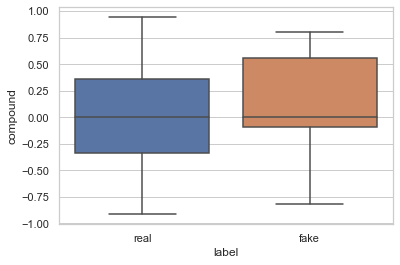

In [154]:
boxplot(data_VADER, "topic_0")

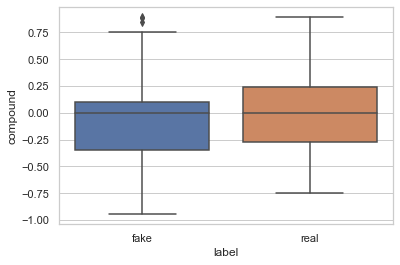

In [155]:
boxplot(data_VADER, "topic_1")

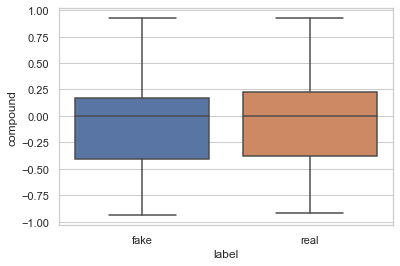

In [156]:
boxplot(data_VADER, "topic_2")

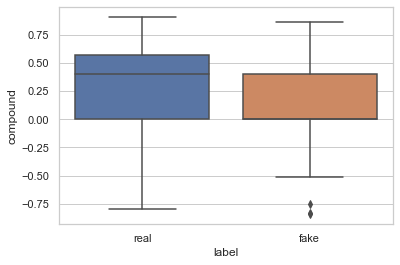

In [157]:
boxplot(data_VADER, "topic_3")

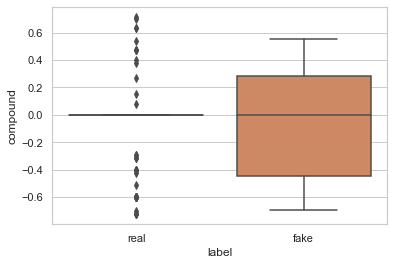

In [158]:
boxplot(data_VADER, "topic_4")

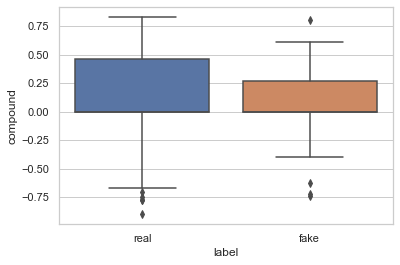

In [159]:
boxplot(data_VADER, "topic_5")

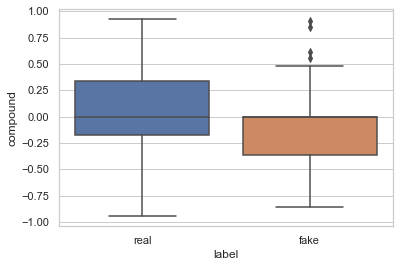

In [160]:
boxplot(data_VADER, "topic_6")

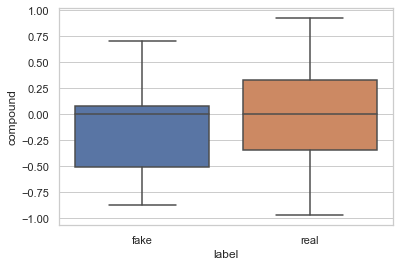

In [161]:
boxplot(data_VADER, "topic_7")

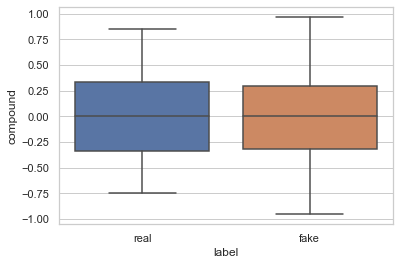

In [162]:
boxplot(data_VADER, "topic_8")

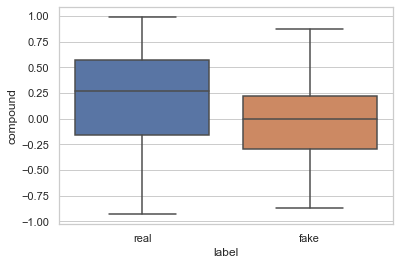

In [163]:
boxplot(data_VADER, "topic_9")

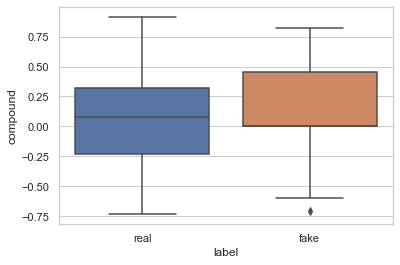

In [164]:
boxplot(data_VADER, "topic_10")

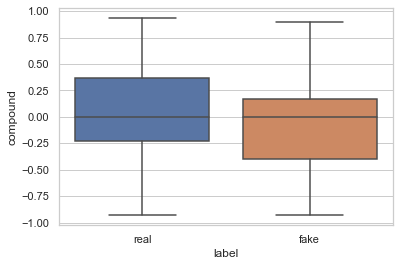

In [165]:
boxplot(data_VADER, "topic_11")

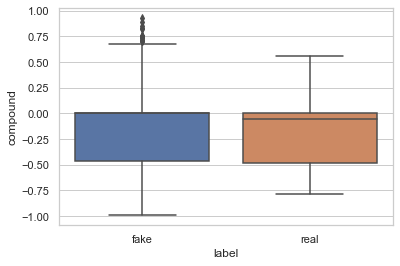

In [166]:
boxplot(data_VADER, "topic_12")

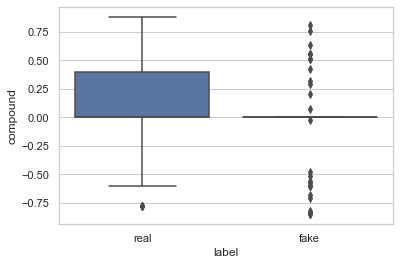

In [167]:
boxplot(data_VADER, "topic_13")

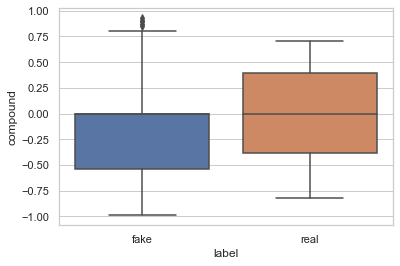

In [168]:
boxplot(data_VADER, "topic_14")

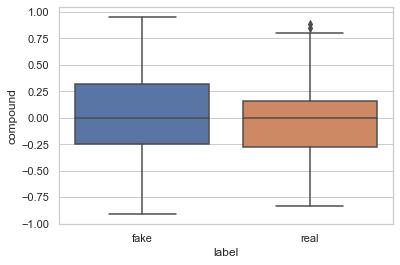

In [169]:
boxplot(data_VADER, "topic_15")

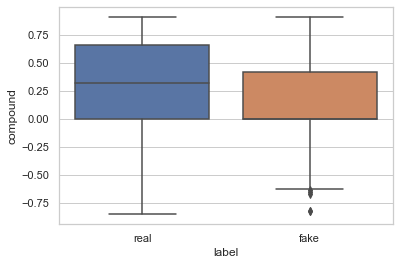

In [170]:
boxplot(data_VADER, "topic_16")

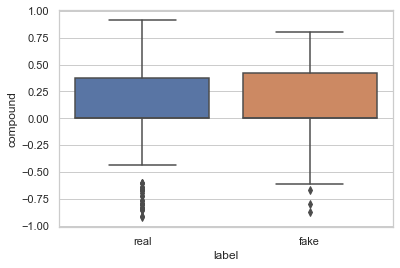

In [171]:
boxplot(data_VADER, "topic_17")

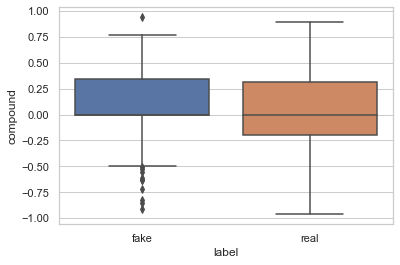

In [172]:
boxplot(data_VADER, "topic_18")

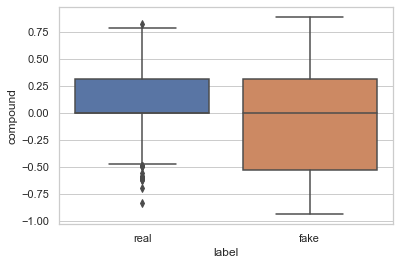

In [173]:
boxplot(data_VADER, "topic_19")

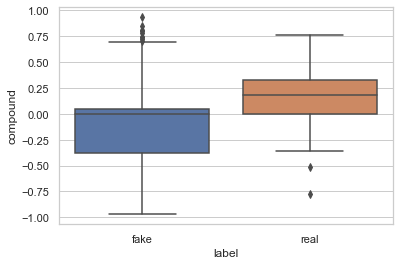

In [174]:
boxplot(data_VADER, "topic_20")

In [175]:
import scipy
scipy.stats.mannwhitneyu(data_VADER[data_VADER.label == "fake"]["compound"], 
                         data_VADER[data_VADER.label == "real"]["compound"])

MannwhitneyuResult(statistic=11660430.5, pvalue=1.8483015783956607e-62)

In [206]:
def dist_plot(data, topic):
    dt = data[data.Max == topic]
    fake = dt[dt.label == "fake"]
    real = dt[dt.label == "real"]
    
    import seaborn as sns
    sns.displot(fake["compound"])
    sns.displot(real["compound"])

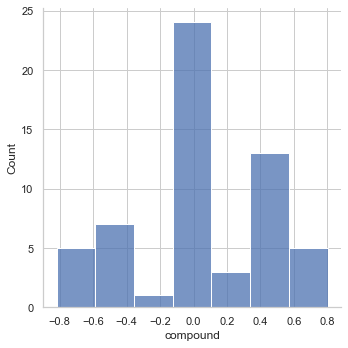

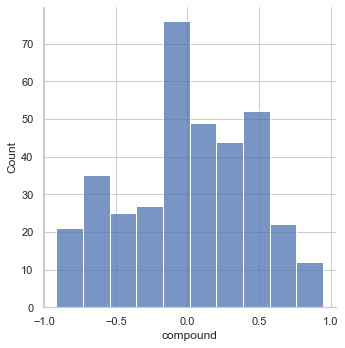

In [207]:
dist_plot(data_VADER, "topic_0")

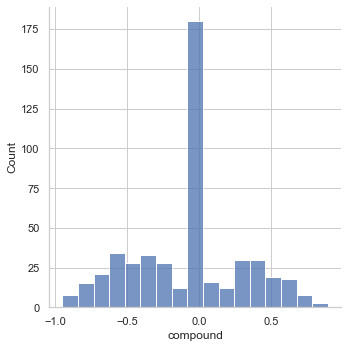

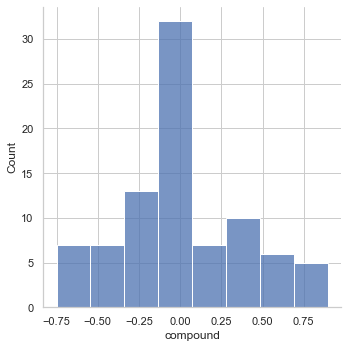

In [209]:
dist_plot(data_VADER, "topic_1")

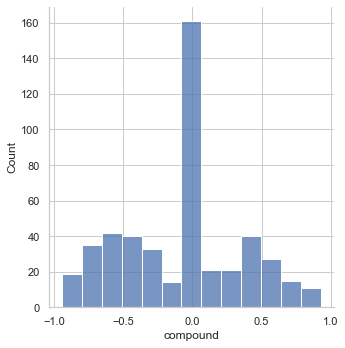

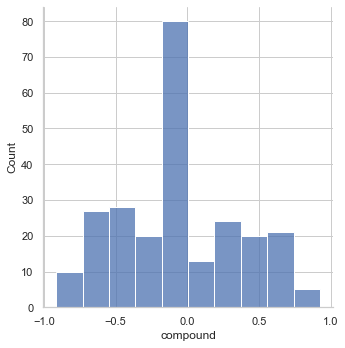

In [210]:
dist_plot(data_VADER, "topic_2")

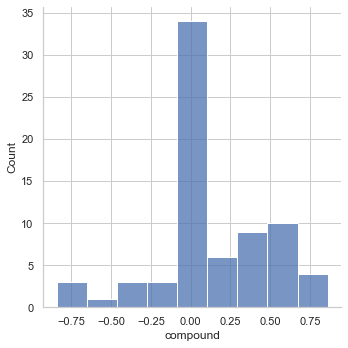

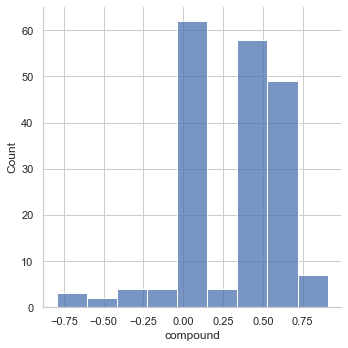

In [211]:
dist_plot(data_VADER, "topic_3")

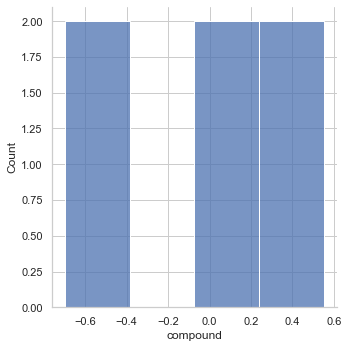

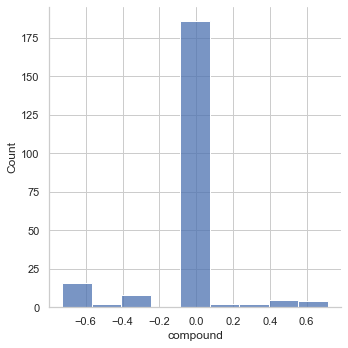

In [212]:
dist_plot(data_VADER, "topic_4")

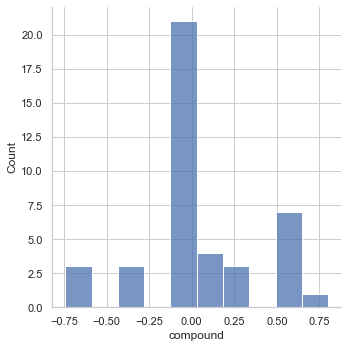

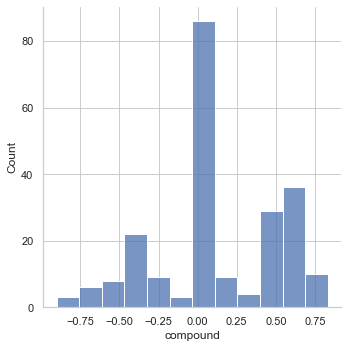

In [213]:
dist_plot(data_VADER, "topic_5")

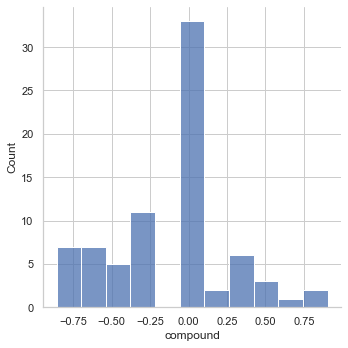

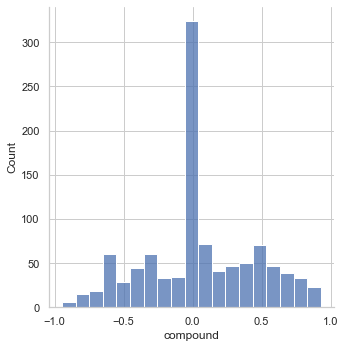

In [214]:
dist_plot(data_VADER, "topic_6")

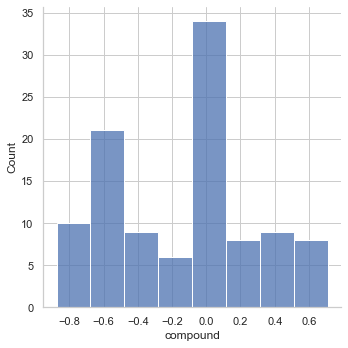

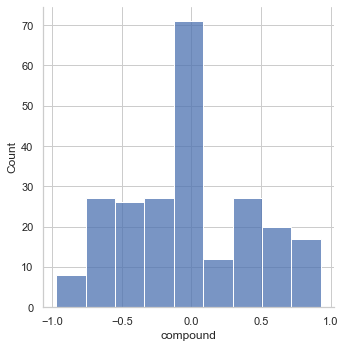

In [215]:
dist_plot(data_VADER, "topic_7")

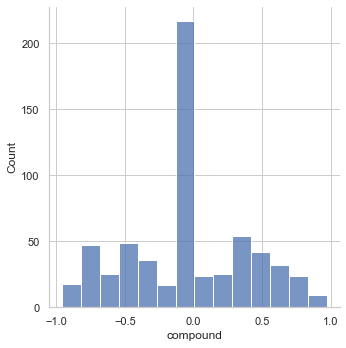

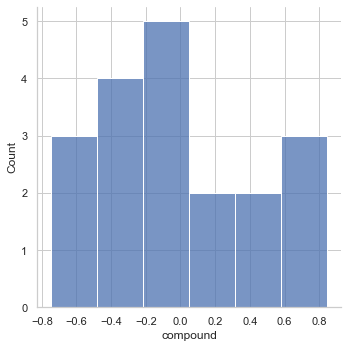

In [216]:
dist_plot(data_VADER, "topic_8")

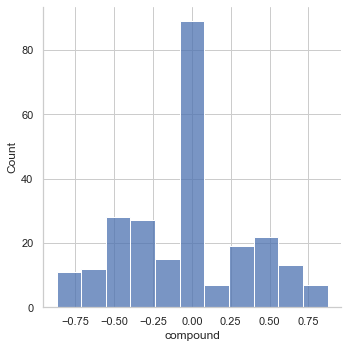

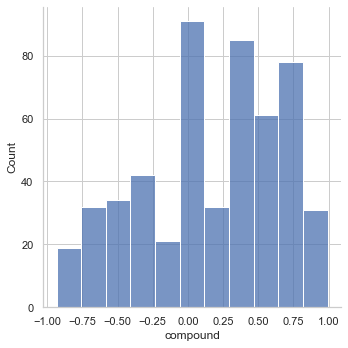

In [217]:
dist_plot(data_VADER, "topic_9")

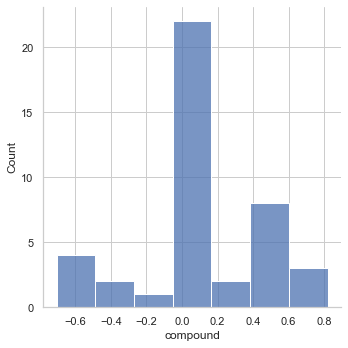

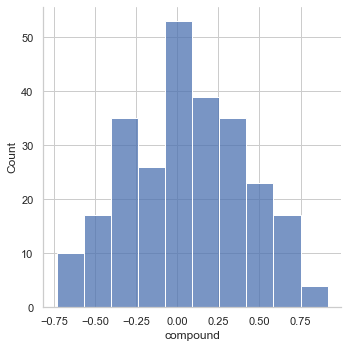

In [218]:
dist_plot(data_VADER, "topic_10")

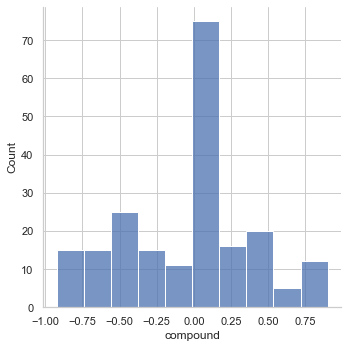

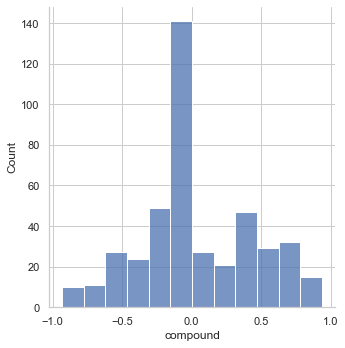

In [219]:
dist_plot(data_VADER, "topic_11")

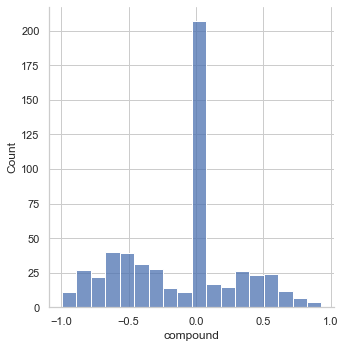

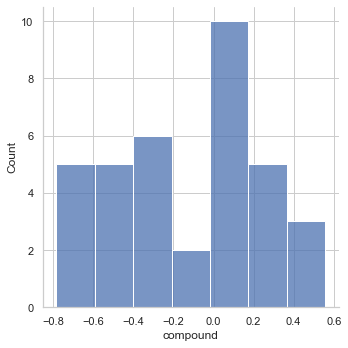

In [220]:
dist_plot(data_VADER, "topic_12")

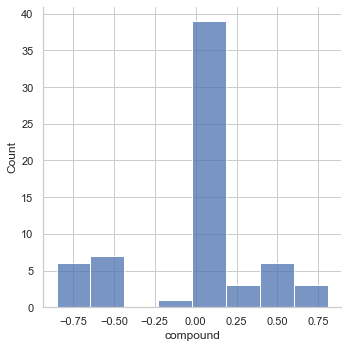

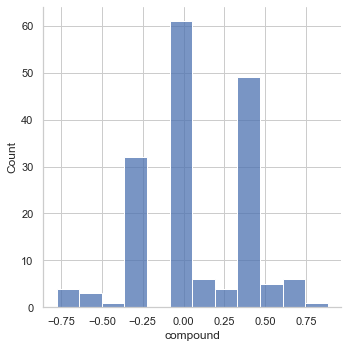

In [221]:
dist_plot(data_VADER, "topic_13")

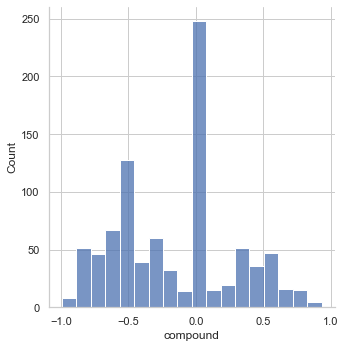

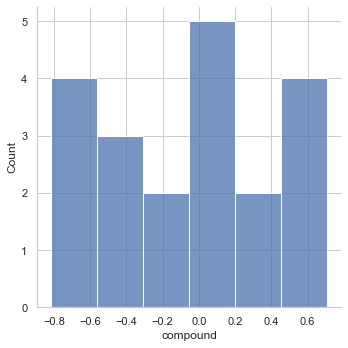

In [222]:
dist_plot(data_VADER, "topic_14")

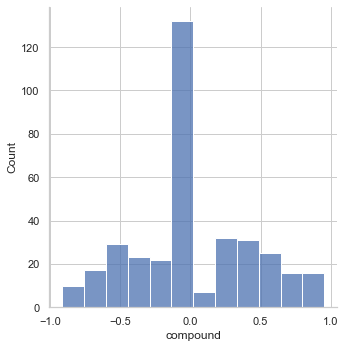

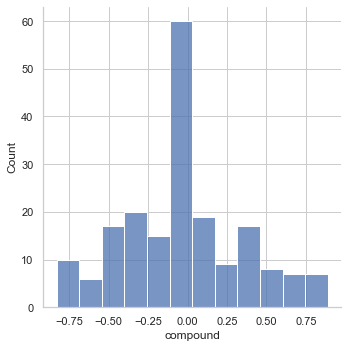

In [223]:
dist_plot(data_VADER, "topic_15")

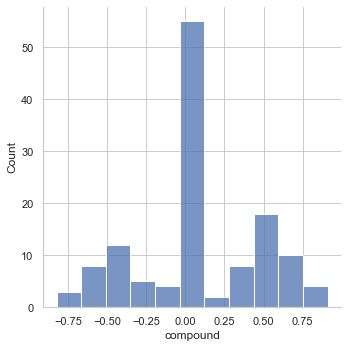

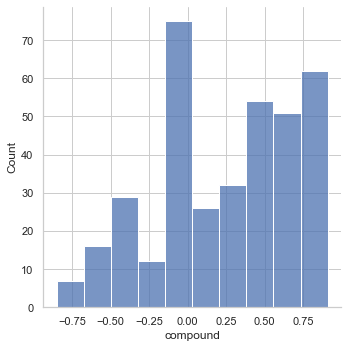

In [224]:
dist_plot(data_VADER, "topic_16")

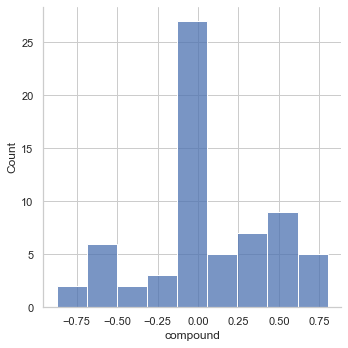

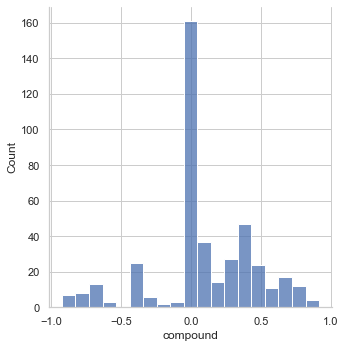

In [225]:
dist_plot(data_VADER, "topic_17")

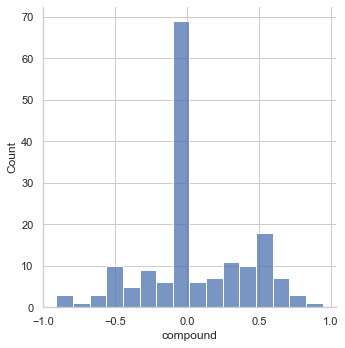

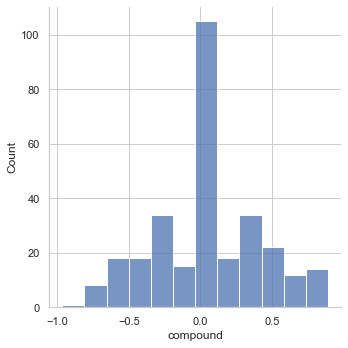

In [226]:
dist_plot(data_VADER, "topic_18")

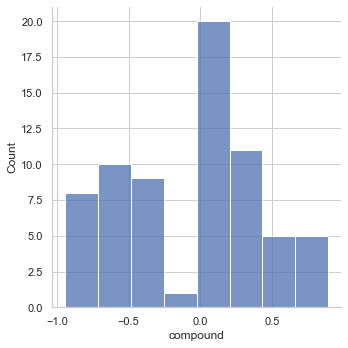

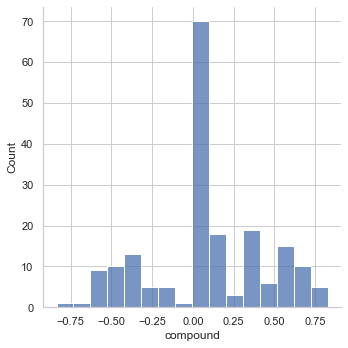

In [227]:
dist_plot(data_VADER, "topic_19")

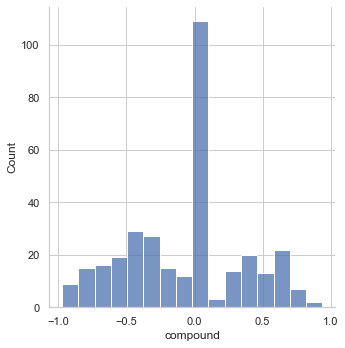

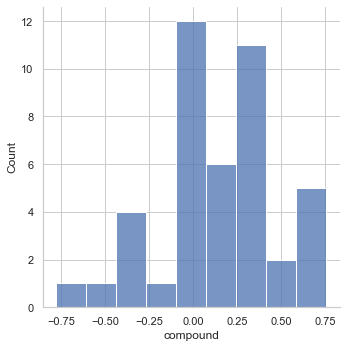

In [228]:
dist_plot(data_VADER, "topic_20")

In [182]:
def mannwhitney_test(data, topic):
    dt = data[data.Max == topic]
    fake = dt[dt.label == "fake"]
    real = dt[dt.label == "real"]
    
    n_fake = len(fake)
    n_real = len(real)
    
    if n_fake or n_real < 
    stat_fake, p = scipy.stats.mannwhitneyu(array(fake["compound"]), array(real["compound"]))
    alpha = 0.05
    #print("p = {:g}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected for {}".format(topic))
    else:
        print("The null hypothesis cannot be rejected for {}".format(topic))

In [183]:
topic_list = ["topic_0", "topic_1", "topic_2", "topic_3", "topic_4", "topic_5", "topic_6", "topic_7",
        "topic_8", "topic_9", "topic_10", "topic_11", "topic_12", "topic_13", "topic_14",
        "topic_15", "topic_16", "topic_17", "topic_18", "topic_19", "topic_20"]
    
for elem in topic_list:
    mannwhitney_test(data_VADER, str(elem))
    #except:
    #    print("Too little data to compute normality for topic {}".format(elem))
    #    pass 
    print(" ")

The null hypothesis cannot be rejected for topic_0
 
The null hypothesis cannot be rejected for topic_1
 
The null hypothesis cannot be rejected for topic_2
 
The null hypothesis can be rejected for topic_3
 
The null hypothesis cannot be rejected for topic_4
 
The null hypothesis cannot be rejected for topic_5
 
The null hypothesis can be rejected for topic_6
 
The null hypothesis can be rejected for topic_7
 
The null hypothesis cannot be rejected for topic_8
 
The null hypothesis can be rejected for topic_9
 
The null hypothesis cannot be rejected for topic_10
 
The null hypothesis can be rejected for topic_11
 
The null hypothesis cannot be rejected for topic_12
 
The null hypothesis can be rejected for topic_13
 
The null hypothesis cannot be rejected for topic_14
 
The null hypothesis cannot be rejected for topic_15
 
The null hypothesis can be rejected for topic_16
 
The null hypothesis cannot be rejected for topic_17
 
The null hypothesis cannot be rejected for topic_18
 
The n

# LIWC

In [134]:
data = pd.read_csv("data_topic_dist.csv")

In [135]:
import liwc
parse, category_names = liwc.load_token_parser('liwc.dic')

In [136]:
def pre_processer_LIWC(corpus):
    corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_rt(text) for text in corpus]
    corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]
    corpus = strip_list_noempty(corpus)
    
    processed_texts = [text for text in nlp.pipe(corpus, 
                                              disable=["ner",
                                                       "parser"])]
    tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] 
                            for lemma_ in processed_texts]
    tokenized_texts = make_n_grams(tokenized_texts)
    
    return tokenized_texts

In [137]:
tokenized_texts = pre_processer_LIWC(data["tweet"])

In [138]:
name_list = ['posemo', 'negemo', 'cause', 'tentat', 'certain',
             'assent', 'nonfl', 'filler', 'swear', 
             'anx', 'anger', 'sad', 'death']

data = data.assign(posemo='', negemo='', cause = '', tentat = '', certain = '',
             assent = '', nonfl = '', filler = '', swear = '', anx = '', anger = '', sad = '', death = '')

result = []
for tweet in tokenized_texts:
    c_counts = Counter(category for token in tweet for category in parse(token))
    c_counts = {k: v for k, v in c_counts.items() if k in name_list}
    result.append(dict(c_counts))
    
for i in range(len(result)):
    c_counts = result[i]
    keys = list(c_counts.keys())
    values = list(c_counts.values())
    for cat in name_list:
        if cat in keys:
            ix = keys.index(cat)
            data.at[i,cat] = values[ix]
        else:
            data.at[i,cat] = 0



In [142]:
data

,tweet,label,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,tentat,certain,assent,nonfl,filler,swear,anx,anger,sad,death
0,The CDC currently reports 99031 deaths. In gen...,real,0.000523,0.000523,0.000523,0.000523,0.000523,0.000523,0.989534,0.000523,...,0,0,0,0,0,0,0,0,0,4
1,States reported 1121 deaths a small rise from ...,real,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.984387,0.000781,...,0,0,0,0,0,0,0,0,0,2
2,Politically Correct Woman (Almost) Uses Pandem...,fake,0.000850,0.000850,0.000850,0.000850,0.000850,0.000850,0.000850,0.000850,...,0,1,0,0,0,0,0,0,0,0
3,#IndiaFightsCorona: We have 1524 #COVID testin...,real,0.141516,0.000671,0.000671,0.000671,0.000671,0.000671,0.000671,0.000671,...,0,0,0,0,0,0,0,0,0,0
4,Populous states can generate large case counts...,real,0.000338,0.000338,0.000338,0.000338,0.000338,0.000338,0.993246,0.000338,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10695,#CoronaVirusUpdates: State-wise details of Tot...,real,0.000271,0.000271,0.000271,0.000271,0.000271,0.000271,0.000271,0.000271,...,0,2,0,0,0,0,0,0,0,0
10696,Tonight 12(midnight) onwards Disaster Manageme...,fake,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,0.000378,...,0,0,0,0,0,0,0,2,0,0
10697,296 new cases of #COVID19Nigeria; Plateau-85 E...,real,0.000350,0.000350,0.000350,0.000350,0.992997,0.000350,0.000350,0.000350,...,0,0,0,0,0,0,0,0,0,1
10698,RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...,real,0.000722,0.000722,0.000722,0.152237,0.000722,0.000722,0.000722,0.000722,...,0,0,0,0,0,0,0,0,0,0


# Results Sentiment Analysis

In [ ]:
data_fake = data[data.label == "fake"]
data_real = data[data.label =="real"]

In [ ]:
data_fake
data_real

###### Loop over documents to get topic distribution: Fake

In [ ]:
transformed_docs = lda_fake.load_document_topics()

In [ ]:
for i, document in enumerate(transformed_docs):
    print('Topic distributions for document {}'.format(i))
    for topic in document:
        print(topic)

In [ ]:
transformed_docs = lda_fake.load_document_topics()
topic_distributions_fake = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=['topic_{}'.format(i) for i in range(8)])
topic_distributions_fake.tail()
topic_distributions_fake.mean().sort_values(ascending=False)

###### Loop over documents to get topic distribution: Real

In [ ]:
transformed_docs = lda_real.load_document_topics()
for i, document in enumerate(transformed_docs):
    print('Topic distributions for document {}'.format(i))
    for topic in document:
        print(topic)

In [ ]:
transformed_docs = lda_real.load_document_topics()
topic_distributions_real = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=['topic_{}'.format(i) for i in range(20)])
topic_distributions_real.tail()
#topic_distributions.mean().sort_values(ascending=False)

## Results: Most distinctive words
This gives an extreme output, why?

In [ ]:
results_df = distinctive_words(flat_real, flat_fake)
results_df.sort_values('llr', ascending=False).head(5)

# SentiWordNet

In [ ]:
import nltk
from nltk.corpus import sentiwordnet as swn
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('sentiwordnet')

In [ ]:
data = pd.read_csv("data_topic_dist.csv")

In [ ]:
# Getting nlp from spacy.load
#nlp=spacy.load('en')
# Making the function to get the sentiments out of the dataframe
def get_sentiment(data, name):
    count=1
    l=len(data)
    positive_sentiments=[]
    negative_sentiments=[]
    for tex in data[name]:
        print('The current status is :',count*100/l,'%')
        tex=nlp(tex)
        noun=[]
        verb=[]
        adj=[]
        adv=[]
        for i in tex :
            if i.pos_=='NOUN':
                noun.append(i)
            elif i.pos_ =='ADJ':
                adj.append(i)
            elif i.pos_ =='VERB':
                verb.append(i)
            elif i.pos_=='ADV':
                adv.append(i)
        clear_output(wait=True)
        count+=1
        neg_score=[]
        pos_score=[]
        for i in tex :
            try:
                if i in noun:
                    x=swn.senti_synset(str(i)+'.n.01')
                    neg_score.append(x.neg_score())
                    pos_score.append(x.pos_score())
                elif i in adj:
                    x=swn.senti_synset(str(i)+'.a.02')
                    neg_score.append(x.neg_score())
                    pos_score.append(x.pos_score())
                elif i in adv :
                    x=swn.senti_synset(str(i)+'.r.02')
                    neg_score.append(x.neg_score())
                    pos_score.append(x.pos_score())
                elif i in verb :
                    x=swn.senti_synset(str(i)+'.v.02')
                    neg_score.append(x.neg_score())
                    pos_score.append(x.pos_score())

            except:
                pass
        positive_sentiments.append(np.mean(pos_score))
        negative_sentiments.append(np.mean(neg_score))

    data['Positive Sentiment']=positive_sentiments
    data['Negative Sentiment']=negative_sentiments

In [ ]:
from IPython.display import clear_output

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

get_sentiment(data, "tweet")

In [ ]:
data.update(data["Negative Sentiment"].mul(-1, 0))

In [ ]:
data

In [ ]:
overall=[]
for i in range(len(data)):
    if data['Positive Sentiment'][i] > 0.05: #data['Negative Sentiment'][i]:
        overall.append('Positive')
    elif data['Negative Sentiment'][i] < -0.05: #data['Negative Sentiment'][i]:
        overall.append('Negative')
    else:
        overall.append('Neutral')
data['Overall Sentiment']=overall

In [ ]:
data_pos = data
data_neg = data

In [ ]:
data_pos

Only run update once!!

In [ ]:
data_pos.update(data_pos.iloc[:, 2:23].mul(data["Positive Sentiment"], 0))

In [ ]:
data_neg.update(data_neg.iloc[:, 2:23].mul(data["Negative Sentiment"], 0))

In [ ]:
data_neg